# Classic

# Code originally by https://github.com/maxjcohen
# My contribution is refine, fix errors and to attempt symbolic representation

In [1]:
import datetime
import os

import sys

sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master')
sys.path.append('C:/Users/rohan/Dissertation/transformer-master - Copy/transformer-master/src')

import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss

from dataset import OzeDataset
from utils import compute_loss
from visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [2]:
# Training parameters
DATASET_PATH = 'dataset/dataset.npz'
BATCH_SIZE = 8#64#8
NUM_WORKERS = 8
LR = 2e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 100#12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 37  # From dataset
d_output = 8  # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("models"):
    os.mkdir("models")

Using device cuda:0


In [3]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

## Training

### Load dataset

In [4]:
import json
# from ABBA import ABBA as ABBA

trial_dataset = np.load(DATASET_PATH)
labels_path = "labels.json"

with open(labels_path, "r") as stream_json:
    labels = json.load(stream_json)

R = trial_dataset['R'].astype(np.float32)
X = trial_dataset['X'].astype(np.float32)
Z = trial_dataset['Z'].astype(np.float32)

print("R shape")
print(np.shape(R))
print("X shape")
print(np.shape(X))
print("Z shape")
print(np.shape(Z))

m = Z.shape[0]  # Number of training example
K = Z.shape[-1]  # Time serie length

Z = Z.transpose((0, 2, 1))
X = X.transpose((0, 2, 1))

R = np.tile(R[:, np.newaxis, :], (1, K, 1))

print("new R shape")
print(np.shape(R))
print("new X shape")
print(np.shape(X))
print("new Z shape")
print(np.shape(Z))

# Store R, Z and X as x and y
_x = np.concatenate([Z, R], axis=-1)
_y = X

print("_x shape")
print(np.shape(_x))

# print("np.shape(_x)")
# print(np.shape(_x))
# print("np.shape(_x)[2]")
# print(np.shape(_x)[2])


# Normalize
# if _normalize == "mean":
mean = np.mean(_x, axis=(0, 1))
std = np.std(_x, axis=(0, 1))
_x = (_x - mean) / (std + np.finfo(float).eps)

_mean = np.mean(_y, axis=(0, 1))
_std = np.std(_y, axis=(0, 1))
_y = (_y - _mean) / (_std + np.finfo(float).eps)

# Using ABBA

# abba = abba=ABBA(max_len=672, verbose=1)

print(np.shape(_x))

dim1 = np.shape(_x)[0]
dim2 = np.shape(_x)[1]
dim3 = np.shape(_x)[2]

pieces = np.empty(shape=(dim1, dim2, dim3))
print(np.shape(pieces))


R shape
(7500, 19)
X shape
(7500, 8, 672)
Z shape
(7500, 18, 672)
new R shape
(7500, 672, 19)
new X shape
(7500, 672, 8)
new Z shape
(7500, 672, 18)
_x shape
(7500, 672, 37)
(7500, 672, 37)
(7500, 672, 37)


In [5]:
# # for i in range(dim1):
# for i in range(10):
#     print("{}th sample _x[i][..][j]".format(i))
# #     for j in range (dim3):
#     for j in range (dim3):
#         print("{}th metric _x[i][..][j]".format(j))
# #         print(_x[i,:,j])
#         print("iteration {} of {}".format((i+1)*(j+1),10*dim3))
#         abbaPieces = abba.compress(_x[i,:,j])
#         print("compression step done")
#         pieces = np.concatenate(pieces,abbaPieces)
#         print("stacking step done")

# print("compression done...")

In [6]:
print(np.shape(pieces))
print(pieces[:])

# # pieces = abba.compress(_x)
# ABBA_string, centers = abba.digitize(pieces.all())
# # Apply inverse transform.
# ABBA_numeric = mean + np.dot(std, abba.inverse_transform(ABBA_string, centers, normalised_time_series[0]))

# # One hot encode symbolic representation. Create list of all symbols
# # in case symbol does not occur in symbolic representation. (example:
# # flat line and insist k>1)
# alphabet = sorted([chr(97+i) for i in range(len(centers))])
# sequence = np.array([[0 if char != letter else 1 for char in alphabet] for letter in ABBA_string])

# Convert to float32

# _x = torch.half(_x)
# _x = torch.half(sequence)
# _y = torch.half(_y)

(7500, 672, 37)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 

In [7]:
ozeDataset = OzeDataset(DATASET_PATH)

In [8]:
dataset_train, dataset_val, dataset_test = random_split(ozeDataset, (5500, 1000, 1000))

dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0,
                              pin_memory=False
                             )

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=0
                           )

dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=0
                            )

### Load network

In [9]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = OZELoss(alpha=0.3)

### Train

[Epoch  30/30]: 100%|██████████| 5500/5500 [03:53<00:00, 23.51it/s, loss=0.000996, val_loss=0.00108]


model exported to models/model_2021_09_22__044505.pth with loss 0.001073


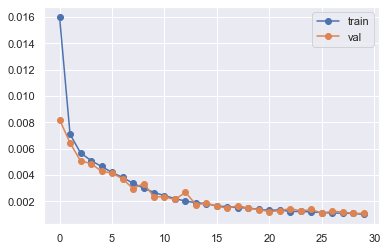

In [10]:
model_save_path = f'models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

## Validation

In [13]:
_ = net.eval()

### Evaluate on the test dataset

In [14]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 672, 8))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

100%|██████████| 125/125 [00:19<00:00,  6.54it/s]


### Plot results on a sample

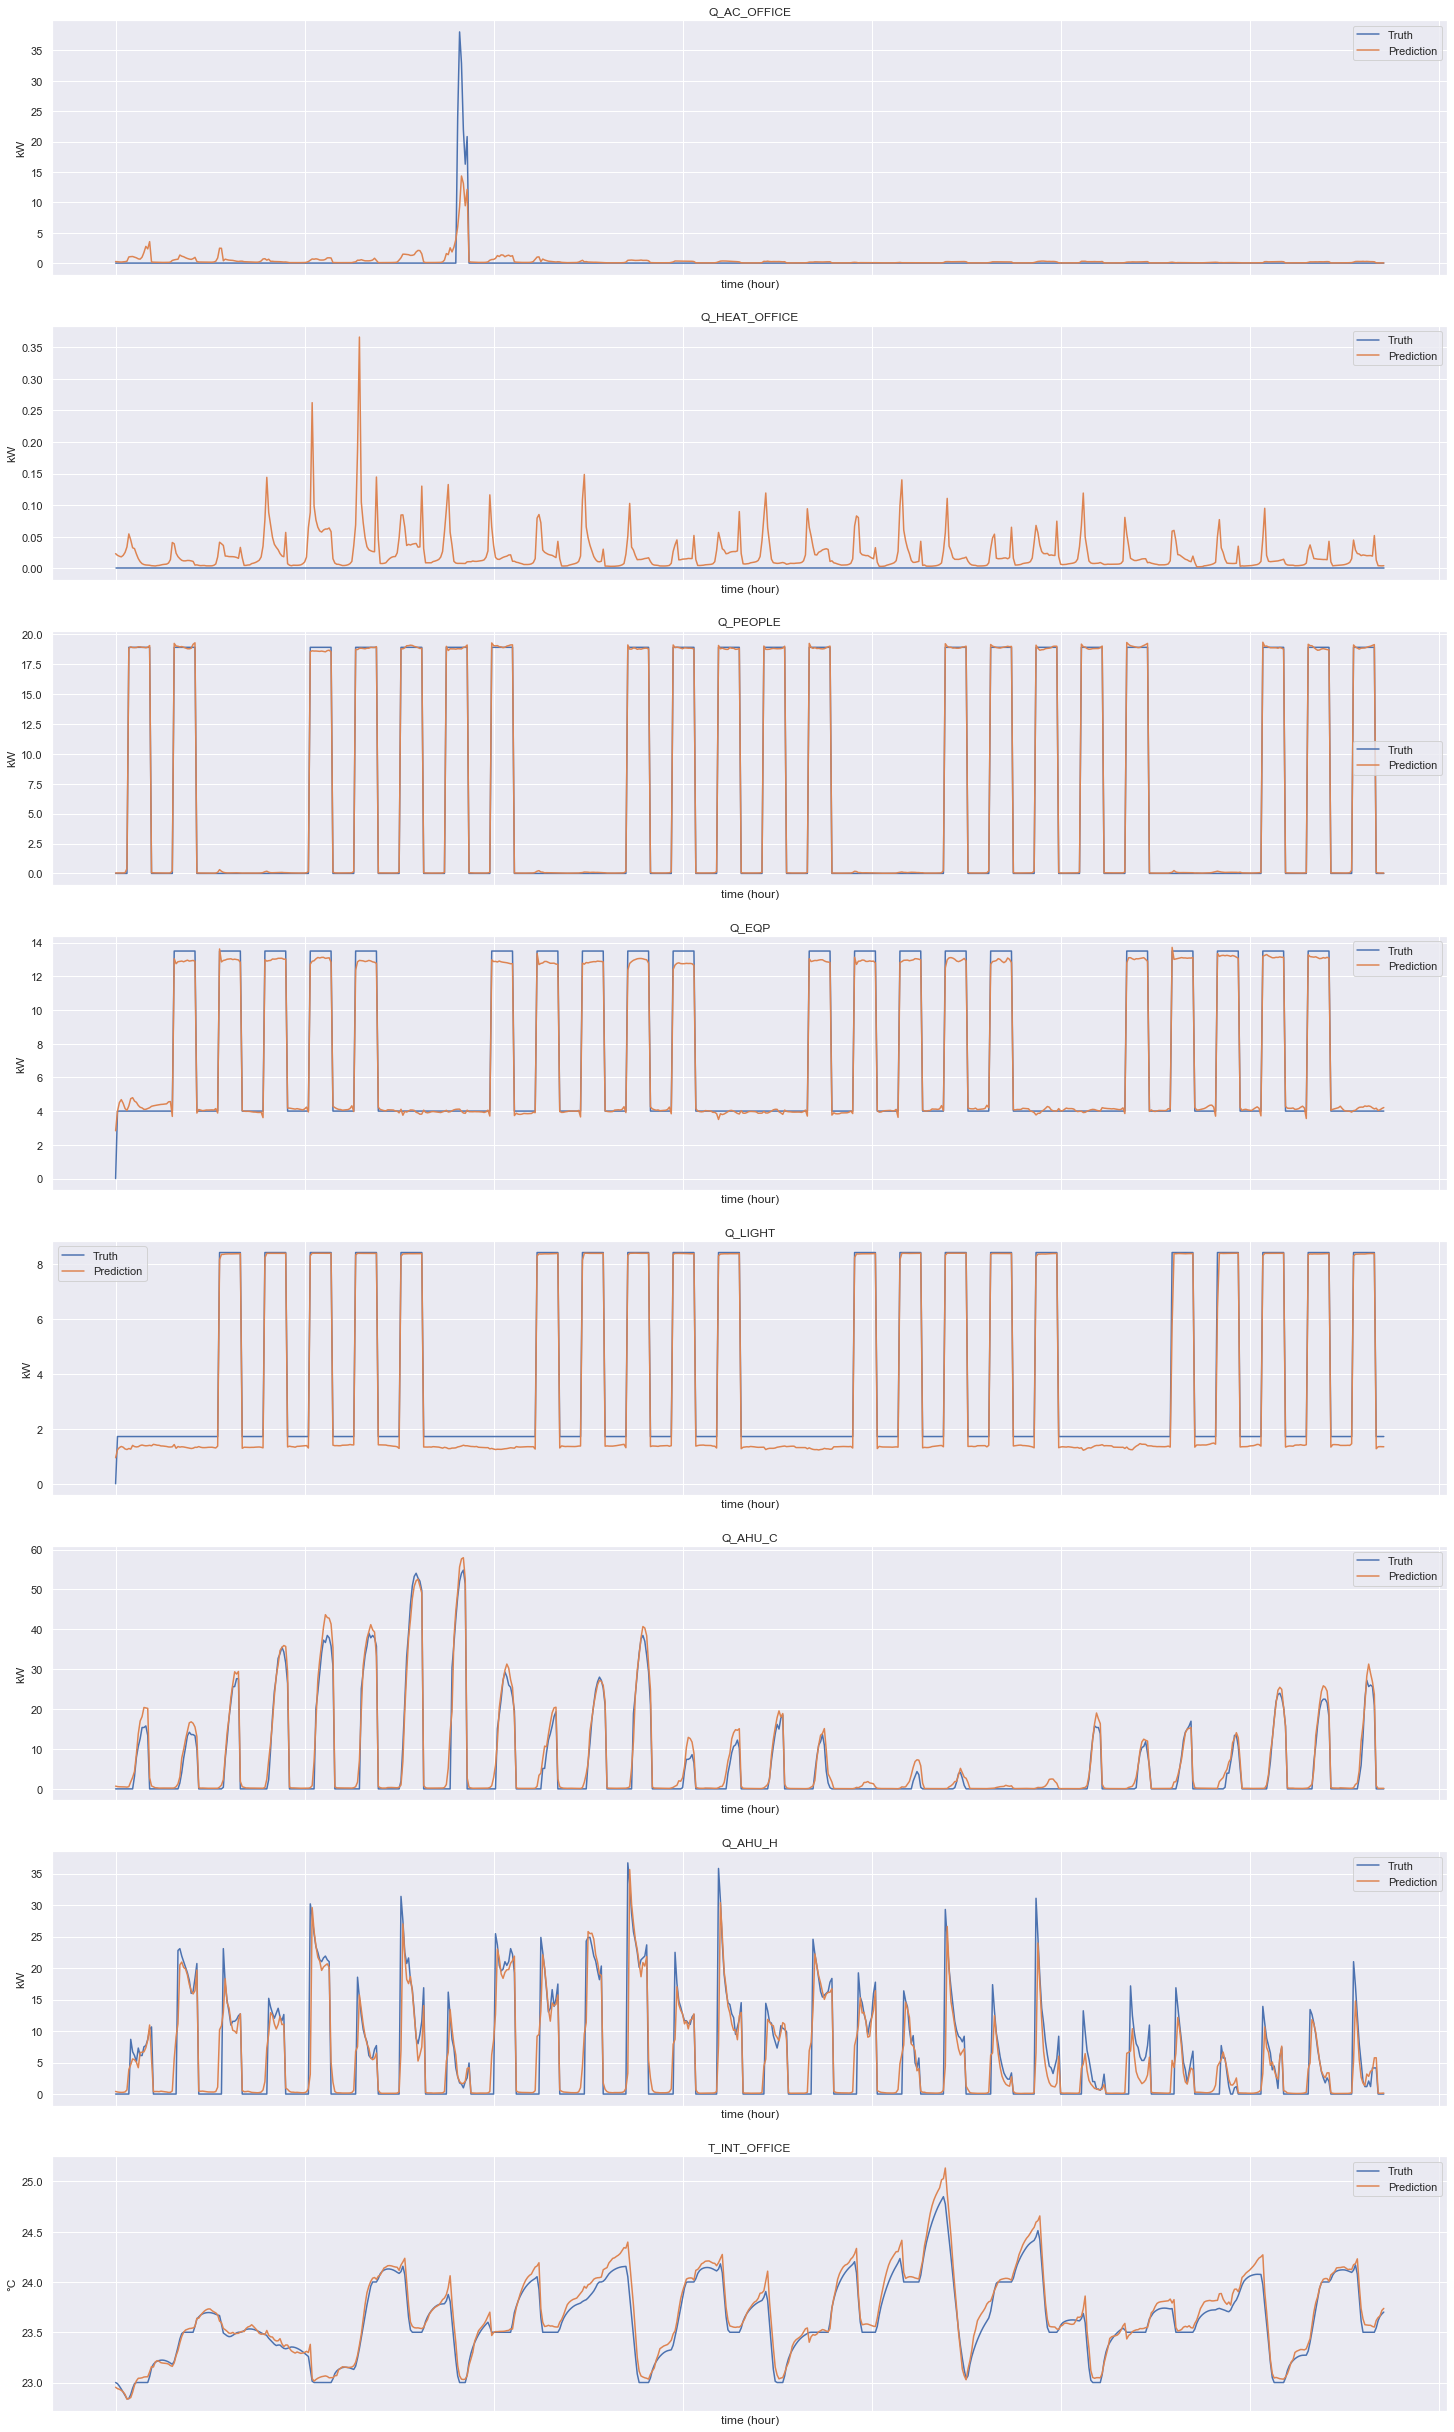

In [15]:
map_plot_function(ozeDataset, predictions, plot_visual_sample, dataset_indices=dataloader_test.dataset.indices)

### Plot error distributions

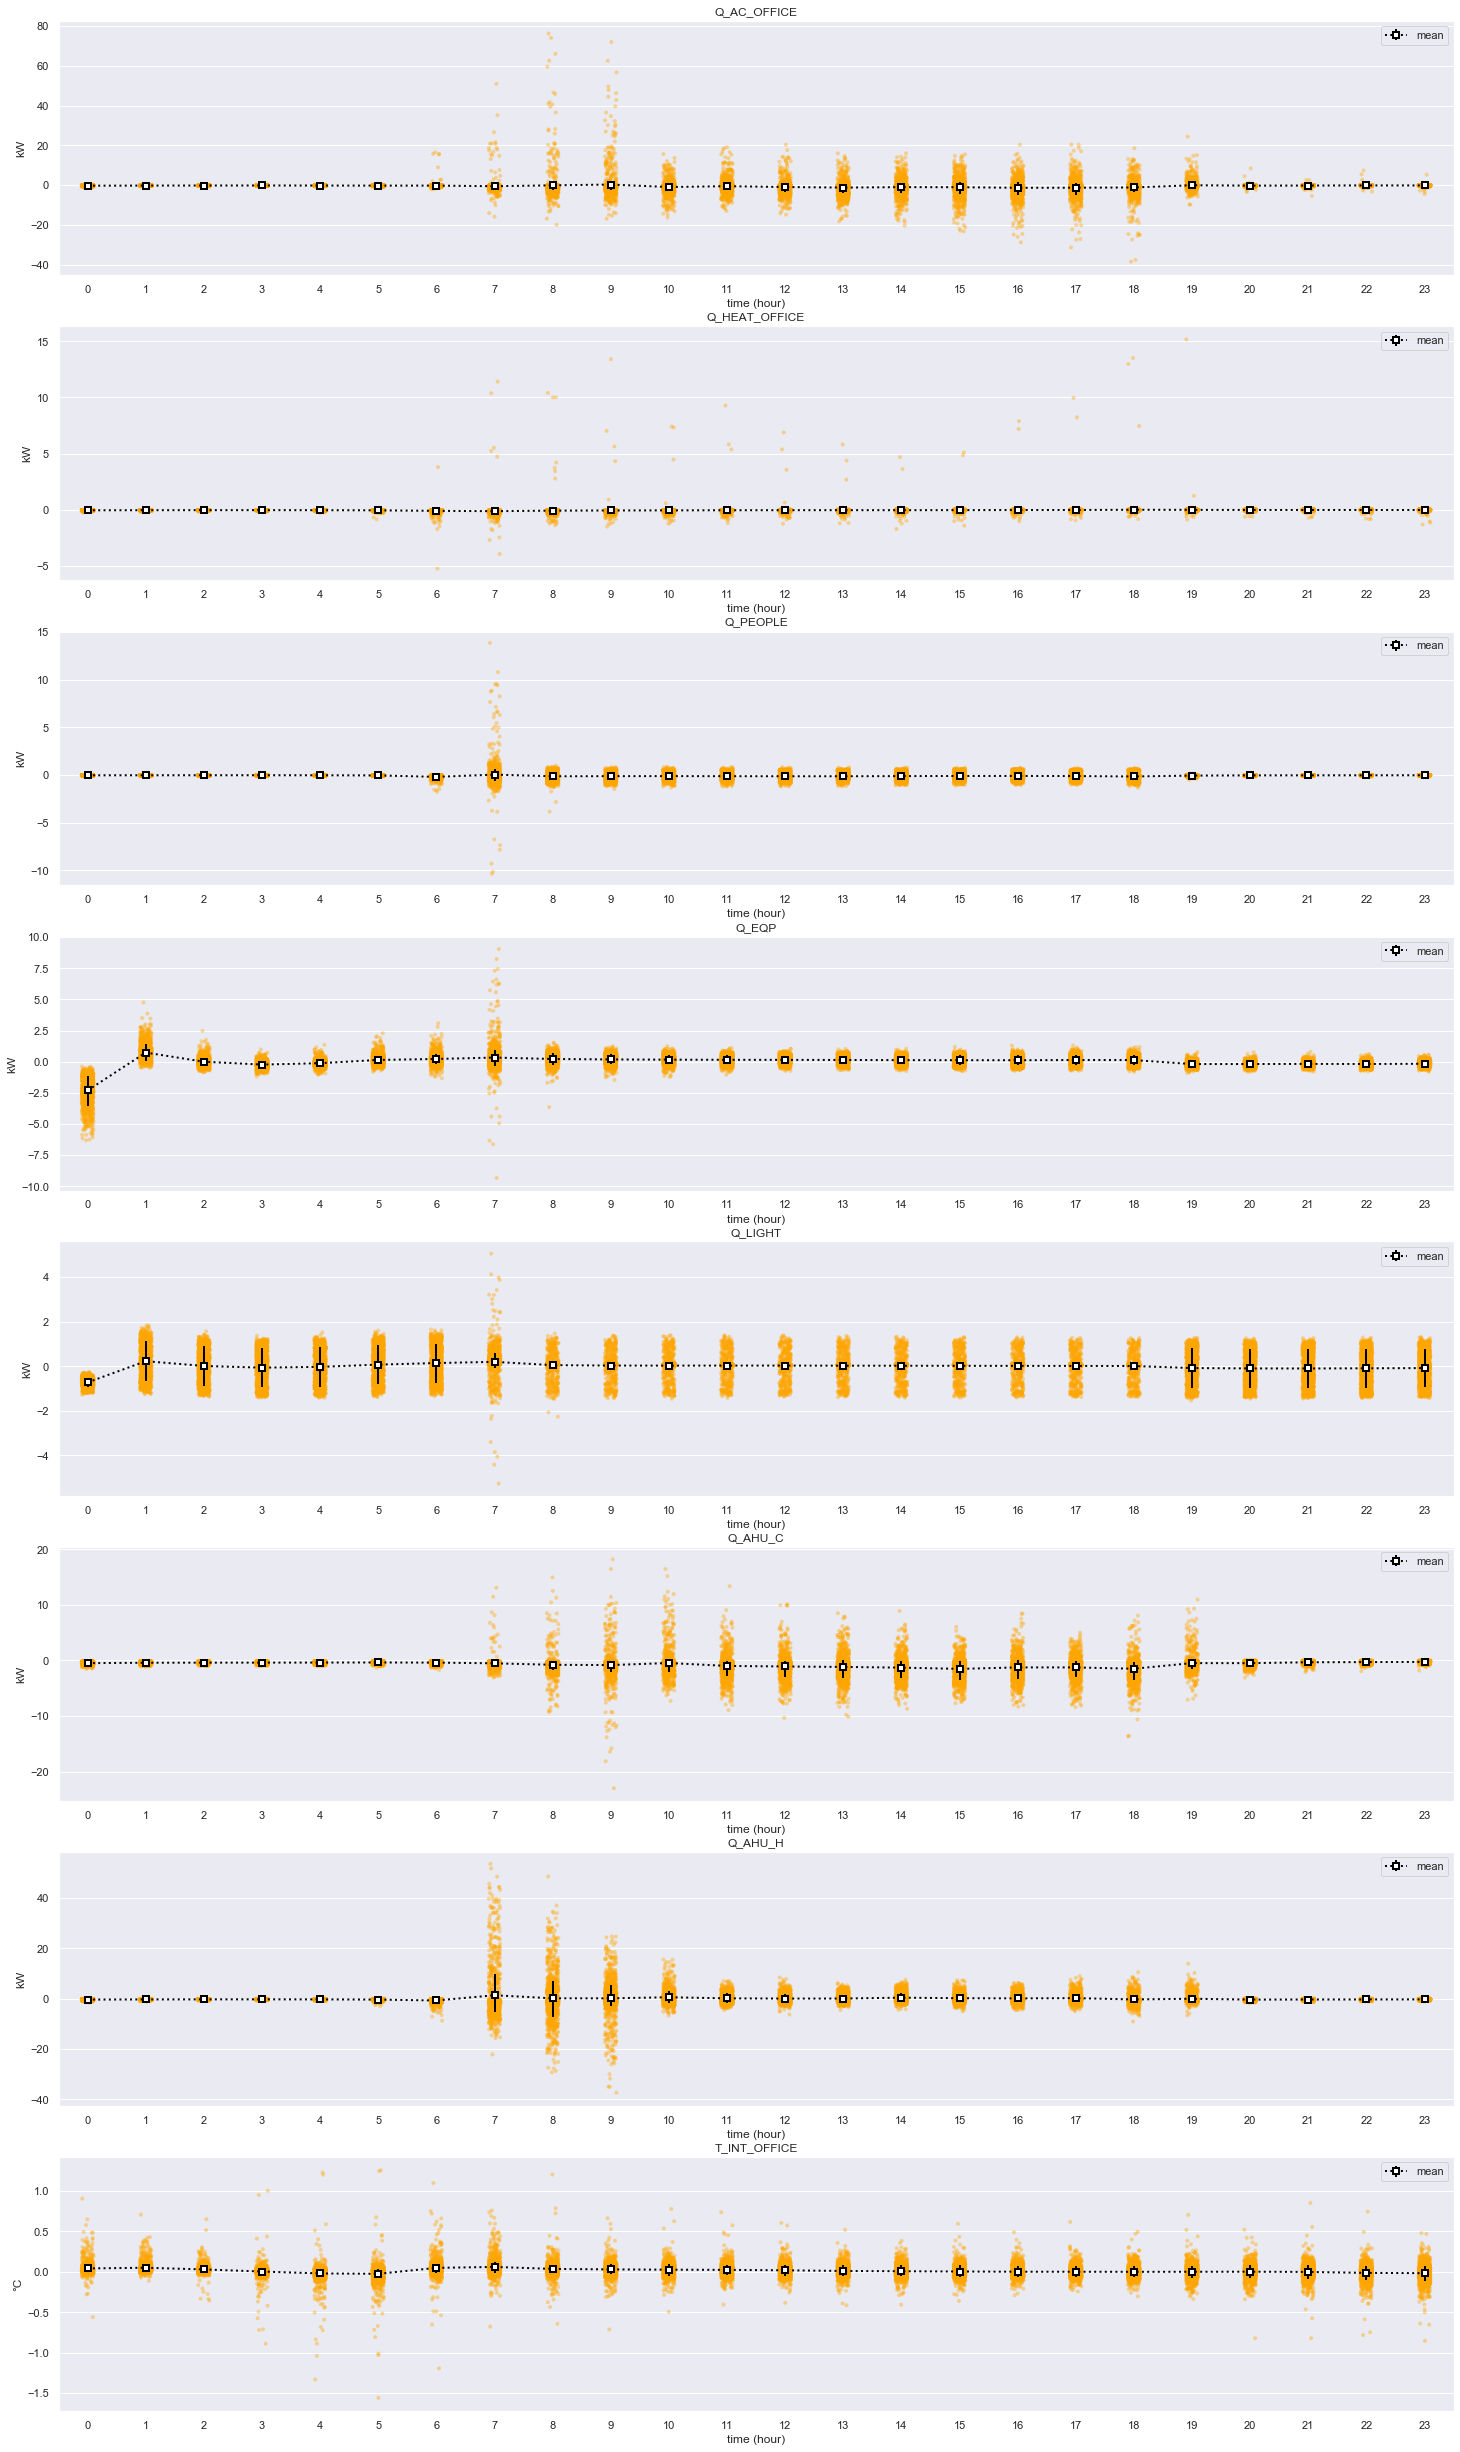

In [16]:
map_plot_function(ozeDataset, predictions, plot_error_distribution, dataset_indices=dataloader_test.dataset.indices, time_limit=24)

### Plot mispredictions thresholds

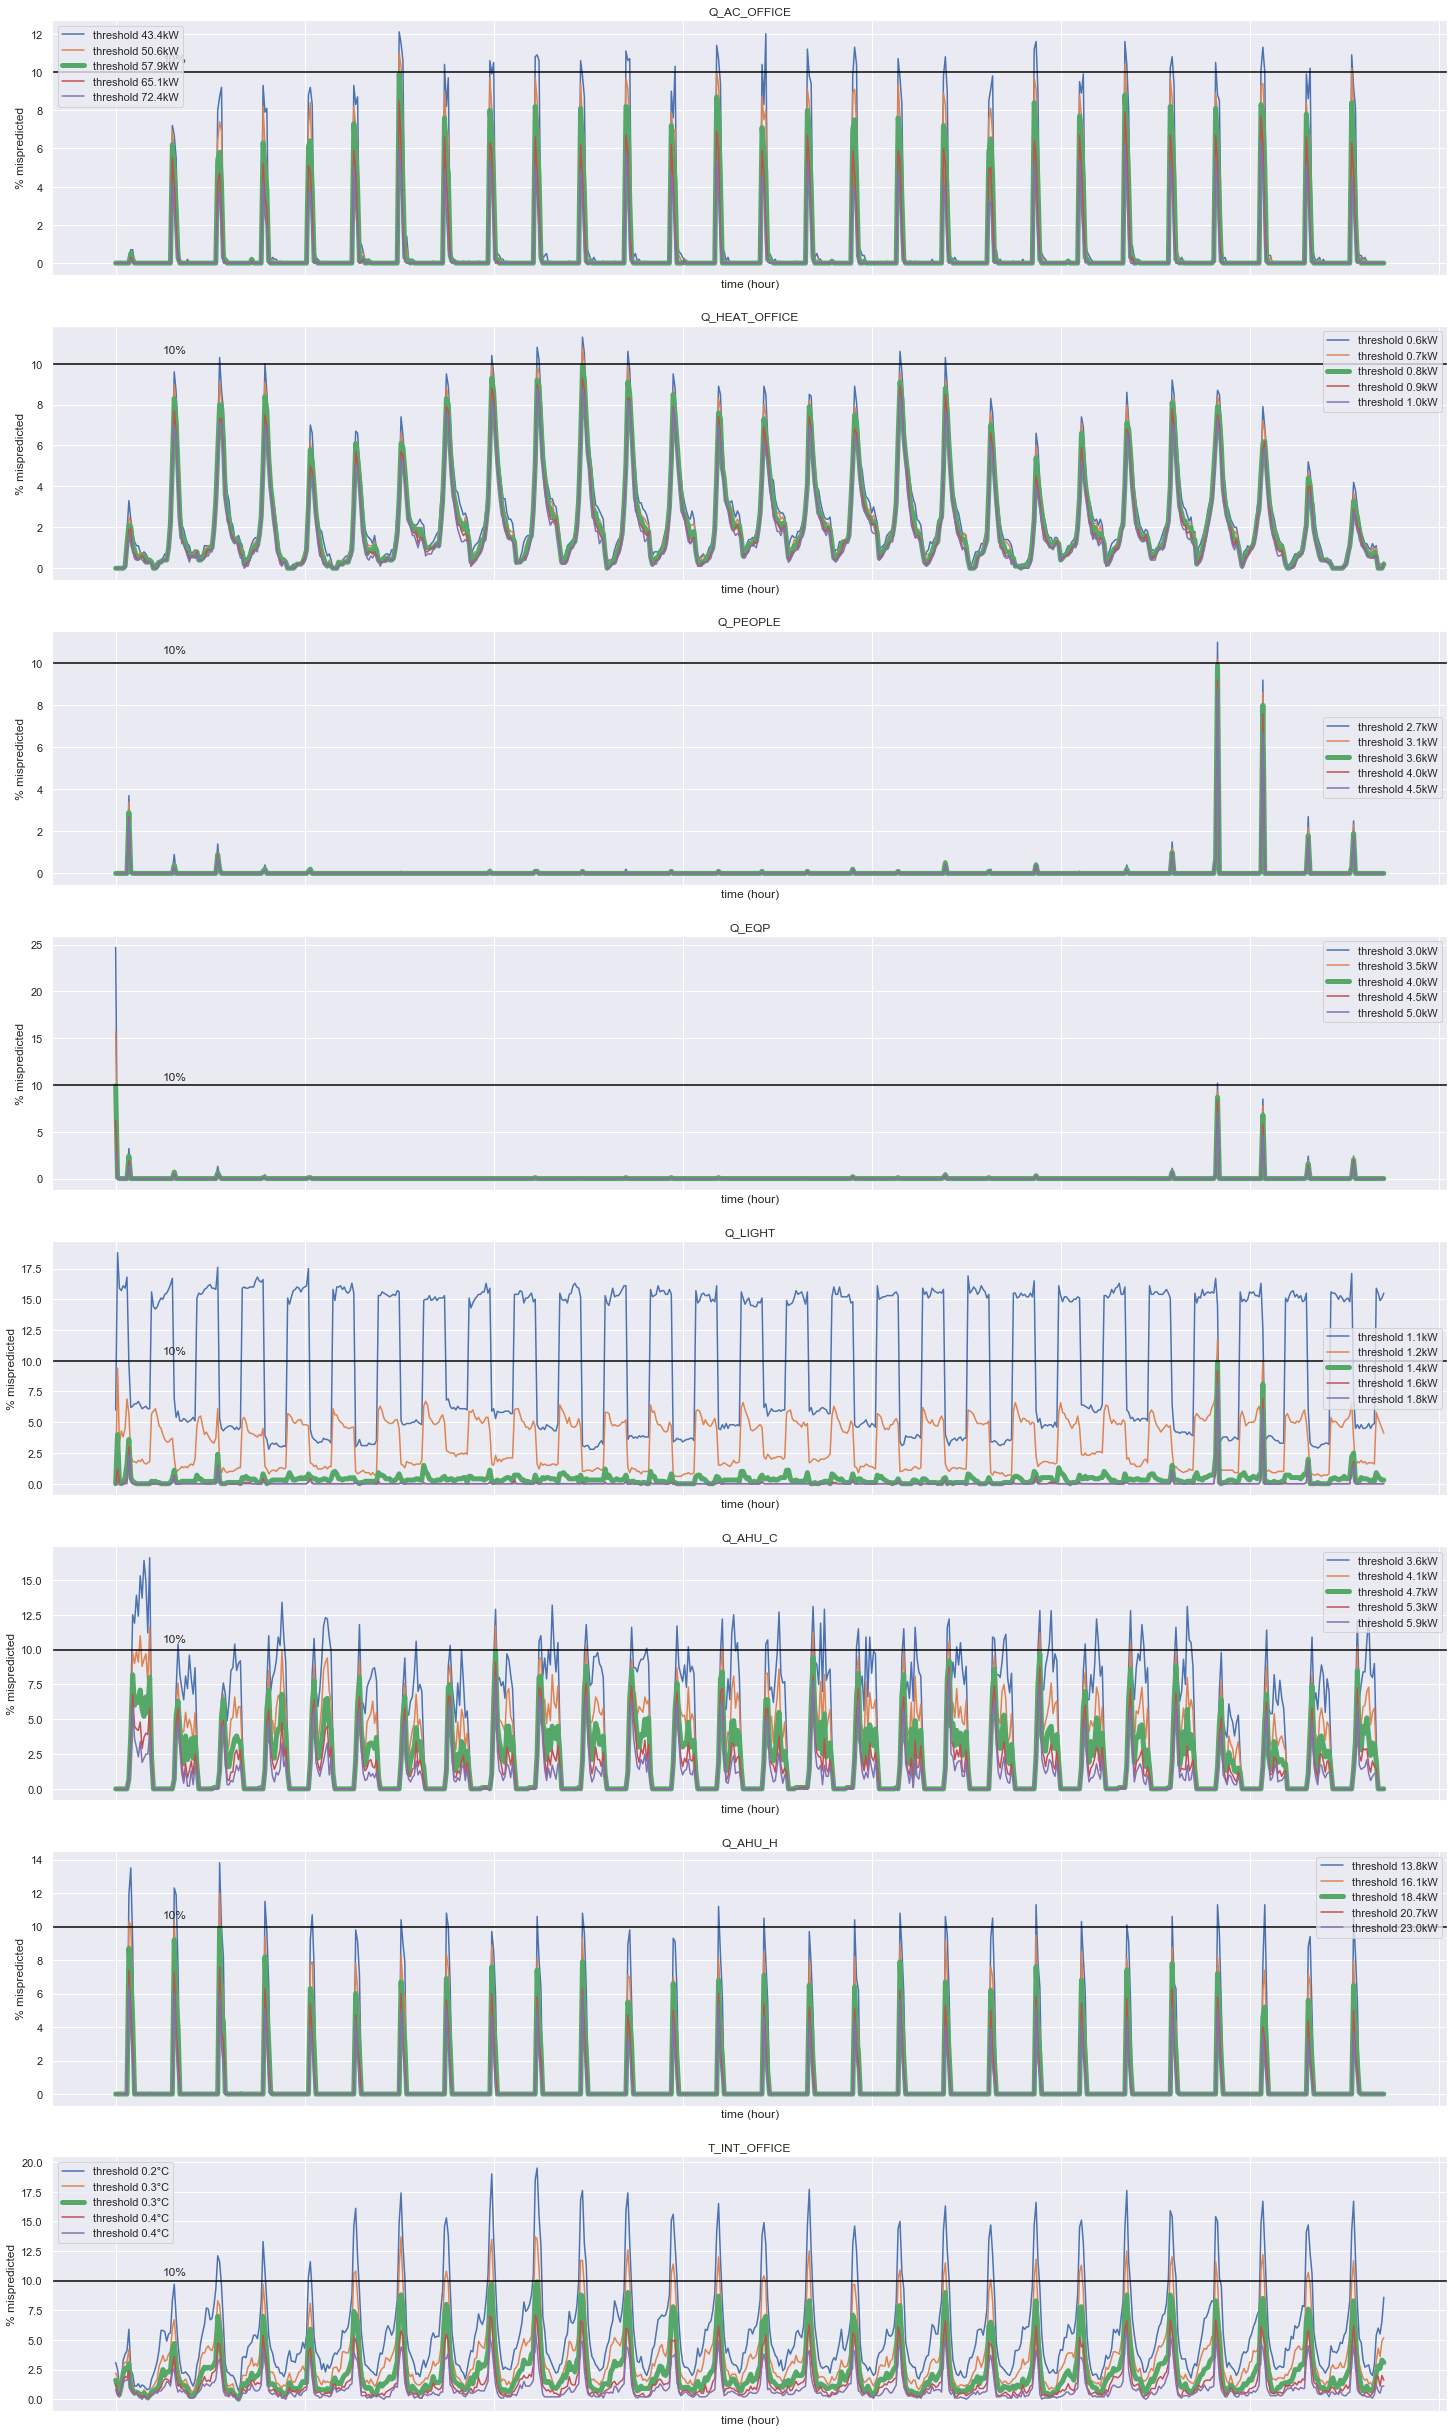

In [17]:
map_plot_function(ozeDataset, predictions, plot_errors_threshold, plot_kwargs={'error_band': 0.1}, dataset_indices=dataloader_test.dataset.indices)

Errors

In [20]:
# print(ozeDataset._y)
expected = ozeDataset._y.numpy()

time_limit = ozeDataset._y.shape[1]
labels = ozeDataset.labels['X']
# print(time_limit)
# print(labels)

forecast_errors = np.zeros((672,8))
for label in labels:
    idx_label = ozeDataset.labels['X'].index(label)
#     print(idx_label)
    y_pred = predictions[:, :time_limit, idx_label]
    y_true = expected[:, :time_limit, idx_label]
    forecast_errors += expected[idx_label]-predictions[idx_label]

# print(forecast_errors)
mean_forecast_error = np.mean(forecast_errors)
mean_squared_error = np.mean(forecast_errors**2)

print("Mean Forecast Error :" + str(mean_forecast_error))
print("Mean Squared Forecast Error :" + str(mean_squared_error))


Mean Forecast Error :0.0003552459371620319
Mean Squared Forecast Error :0.3628094751867939
